In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
from sklearn.metrics import r2_score
from sklearn import ensemble, linear_model, metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from tqdm import *

plt.style.use('ggplot')
pd.options.mode.chained_assignment = None


def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight,
                  multioutput=multioutput)
    r = (np.sign(r2) * np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r


def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')


# import kagglegym
# env = kagglegym.make()
# o = env.reset()
# train = o.train

train = pd.read_hdf('../input/train.h5')

low_y_cut = -0.086093
high_y_cut = 0.093497

y_is_above_cut = (train.y > high_y_cut)
y_is_below_cut = (train.y < low_y_cut)
y_is_within_cut = (~y_is_above_cut & ~y_is_below_cut)
train = train.loc[y_is_within_cut, :]

d_mean = train.median(axis=0)
train["nbnulls"] = train.isnull().sum(axis=1)
col = [x for x in train.columns if x not in ['id', 'timestamp', 'y']]

rnd = 17

# columns kept for evolution from one month to another (best selected by the tree algorithms)
add_diff_ft = True
diff_cols =  ['technical_17', 'technical_30', 'technical_33',
       'technical_11', 'technical_20', 'technical_21',
       'technical_2', 'technical_24', 'technical_41', 'technical_3',
       'technical_19', 'technical_40', 'technical_27', 'technical_6',
       'technical_35', 'technical_1', 'technical_31', 'fundamental_44']

if add_diff_ft:
    train = train.sort_values(by=['id', 'timestamp'])
    for elt in diff_cols:
        # a quick way to obtain deltas from one month to another but it is false on the first
        # month of each id
        train[elt + "_d"] = train[elt].rolling(2).apply(lambda x: x[1] - x[0]).fillna(0)
        gc.collect()
    # removing month 0 to reduce the impact of erroneous deltas
    train = train[train.timestamp != 0]

bad_cols = ['technical_32', 'fundamental_3', 'fundamental_9', 'technical_34',
       'fundamental_27', 'technical_10', 'technical_18', 'fundamental_28',
       'technical_39', 'fundamental_63', 'fundamental_26',
       'fundamental_61', 'fundamental_1', 'technical_22', 'fundamental_38',
       'fundamental_6', 'technical_9', 'fundamental_57']
cols = [x for x in train.columns if x not in (['id', 'timestamp', 'y', 'sample'] + bad_cols)]

In [ ]:
verbose = 1
plot = 1
params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'regression',
    'verbose': verbose,
    # 'num_leaves': 1024,
    # 'learning_rate': 0.05,
    # 'feature_fraction': 0.9,
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    # 'max_bin': 512,
    # 'num_iterations':20
}

X_train, X_test, y_train, y_test = train_test_split(train[cols], train.y, test_size=0.2, random_state=0)
train_data = lgb.Dataset(X_train, y_train)
gc.collect()
bst = lgb.train(params, train_data, feval=r_score, verbose_eval=verbose)

df_fi = pd.DataFrame(bst.feature_name(), columns=['feature'])
df_fi['importance'] = list(bst.feature_importance('gain'))
df_fi.sort_values('importance', ascending=False, inplace=True)
print_full(df_fi)
if plot:
    plt.figure()
    df_fi.head(10).plot(kind='barh',
                        x='feature',
                        y='importance',
                        sort_columns=False,
                        legend=False,
                        figsize=(10, 6),
                        facecolor='#1DE9B6',
                        edgecolor='white')

    plt.title('LightGBM Feature Importance')
    plt.xlabel('relative importance')
    plt.show()

if verbose:
    y_pred = bst.predict(X_test)
    print('\nScore for another fold: ', r_score(y_test, y_pred))

In [25]:
df_fi = pd.read_csv('fi.txt', delim_whitespace=True)
top_cols = df_fi['feature'].iloc[:20]
worst_cols = df_fi['feature'].iloc[-20:]

In [2]:
from tsne import bh_sne
X_2d = bh_sne(train[cols])

SystemError: Parent module '' not loaded, cannot perform relative import

In [71]:
gc.collect()
fi = pd.read_csv('fi.txt', delim_whitespace=True)
fi['feature'].values

array(['derived_1', 'technical_24', 'fundamental_17', 'derived_2',
       'fundamental_61', 'fundamental_51', 'technical_3', 'id',
       'timestamp', 'fundamental_27', 'fundamental_11', 'fundamental_9',
       'technical_0', 'fundamental_56', 'fundamental_25', 'fundamental_49',
       'technical_37', 'fundamental_55', 'fundamental_53',
       'fundamental_38', 'fundamental_5', 'technical_41', 'fundamental_59',
       'fundamental_6', 'fundamental_7', 'fundamental_2', 'technical_12',
       'fundamental_43', 'fundamental_10'], dtype=object)

In [65]:
imp_cols = fi['feature'].values[:30]
imp_cols

array(['technical_30_d', 'technical_17', 'technical_30', 'technical_33',
       'technical_11', 'technical_20', 'technical_21', 'technical_20_d',
       'technical_2', 'technical_24', 'technical_41', 'technical_3',
       'technical_19', 'technical_40', 'technical_27', 'technical_6',
       'technical_35', 'technical_1', 'technical_31', 'fundamental_44',
       'technical_44', 'technical_36', 'technical_0', 'fundamental_62',
       'technical_28', 'technical_5', 'technical_25', 'fundamental_0',
       'fundamental_42', 'technical_7'], dtype=object)

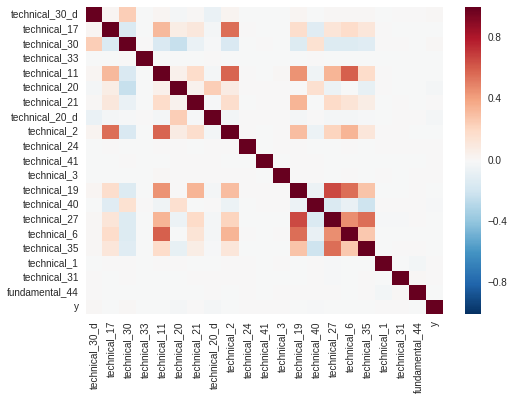

In [54]:
import seaborn as sns
sns.heatmap(train[imp_cols].corr())